# 

In [89]:
%run ../utils-notebook/plot.py
%run ../utils-notebook/load_data.py
%run ../utils-notebook/clustering.py
%run ../utils-notebook/dimensionality_reduction.py
%run ../utils-notebook/validate.py


# hdbscan lambdaごと

In [44]:
import hdbscan
import numpy as np
from sklearn.datasets import make_blobs

# --- 1. データ生成 ---
# 3つのクラスタを持つサンプルデータを生成
n_samples = 500
centers = [(1, 1), (-1, -1), (2, -2)]
X, true_labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.4, random_state=42)

# --- 2. HDBSCANの実行 ---
# クラスタリングを実行し、ツリー情報を取得
min_cluster_size = 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            core_dist_n_jobs=-1,
                            gen_min_span_tree=True,
                            ).fit(X)

# --- 3. 特定の階層でクラスタリング結果を抽出する関数 ---

def get_clusters_at_lambda(clusterer, target_lambda):
    """
    HDBSCANの単一リンケージツリーから、指定されたラムダ値に対応する
    距離でカットしたクラスタリング結果（ラベル）を取得する。
    """
    # ラムダ値を距離（イプシロン）に変換
    if target_lambda <= 0:
        # ラムダが0以下は無限大の距離に相当するため、単一のクラスタと見なす
        return np.zeros(len(clusterer.labels_), dtype=int), 1

    epsilon = 1.0 / target_lambda
    
    # 単一リンケージツリーを取得
    # raw_treeは (child1, child2, distance, size) の形式のレコードアレイ
    raw_tree = clusterer.single_linkage_tree_.to_numpy()
    n_points = len(X)
    
    # Union-Find構造の初期化
    # 各点を個別のクラスタとして初期化
    parent = np.arange(n_points)

    def find(i):
        if parent[i] == i:
            return i
        parent[i] = find(parent[i])
        return parent[i]

    def union(i, j, current_label):
        root_i = find(i)
        root_j = find(j)
        if root_i != root_j:
            # ラベル付けのために、親を新しいクラスタIDに設定
            # ここでは単純にインデックスの小さい方を親としてマージ
            if root_i < root_j:
                parent[root_j] = root_i
                return True
            else:
                parent[root_i] = root_j
                return True
        return False

    # 距離の小さい（高密度の、大きなラムダ）結合から順に処理
    # raw_treeは既に距離の昇順（ラムダの降順）でソートされている
    
    # 処理すべきノードID（データ点ID: 0 to n_points-1, クラスタノードID: n_points to n_points + n_clusters - 2）
    # 単一リンケージツリーのレコードは、データ点とクラスタノードの結合イベントを表す
    
    # ノード ID の最大値を取得
    num_nodes = len(raw_tree) + n_points
    
    # 各ノードの親を初期化 (最初はすべて自分自身)
    node_parent = np.arange(num_nodes)

    def find_node(i):
        if node_parent[i] == i:
            return i
        node_parent[i] = find_node(node_parent[i])
        return node_parent[i]

    def union_node(i, j):
        root_i = find_node(i)
        root_j = find_node(j)
        if root_i != root_j:
            # より安定した（高密度の）方を親にしたいが、ここでは単純にインデックスの小さい方を親に
            if root_i < root_j:
                node_parent[root_j] = root_i
                return True
            else:
                node_parent[root_i] = root_j
                return True
        return False

    # クラスタノードID (n_points から始まる)
    cluster_node_id = n_points
    
    # 単一リンケージツリーの結合イベントを順に処理
    for row in raw_tree:
        # child1とchild2は、結合する2つのノードID
        child1, child2, dist, _ = row
        
        # 指定されたイプシロン（距離）より小さい距離での結合のみを考慮
        if dist <= epsilon:
            # 結合を実行
            union_node(int(child1), int(child2))
            
            # このイベントで誕生したクラスタノードIDをインクリメント
            cluster_node_id += 1
        else:
            # 距離がターゲットを超えたため、これ以上は結合しない（カットライン）
            break
            
    # 最終的なラベル付け
    # データ点ID (0からn_points-1) の連結成分ルートIDを取得
    labels = np.zeros(n_points, dtype=int)
    unique_roots = {}
    label_counter = 0

    for i in range(n_points):
        root = find_node(i)
        if root not in unique_roots:
            unique_roots[root] = label_counter
            label_counter += 1
        labels[i] = unique_roots[root]
        
    return labels, label_counter

# --- 4. 実行例 ---

# HDBSCANが自動で選択したラムダ (例: 0.8) に近い値を指定
target_lambda_high_density = 1.0 / clusterer.minimum_spanning_tree_._data.min() * 2 # 適当に高めのラムダ
target_lambda_low_density = 0.5 # 適当に低めのラムダ

# HDBSCANの最終的なラベル
final_labels = clusterer.labels_

# 指定したラムダでのラベルを抽出
labels_high, num_high = get_clusters_at_lambda(clusterer, target_lambda_high_density)
labels_low, num_low = get_clusters_at_lambda(clusterer, target_lambda_low_density)

print(f"--- HDBSCAN 最終クラスタリング ---")
print(f"クラスタ数 (ノイズを除く): {len(np.unique(final_labels[final_labels != -1]))}")

print(f"\n--- 高いλでのカット (局所的な密度のクラスタ) ---")
print(f"対象 λ: {target_lambda_high_density:.2f}")
print(f"抽出されたクラスタ数: {num_high}")
print(f"抽出されたラベルの最初の10点: {labels_high[:10]}")

print(f"\n--- 低いλでのカット (広域的な密度のクラスタ) ---")
print(f"対象 λ: {target_lambda_low_density:.2f}")
print(f"抽出されたクラスタ数: {num_low}")
print(f"抽出されたラベルの最初の10点: {labels_low[:10]}")

--- HDBSCAN 最終クラスタリング ---
クラスタ数 (ノイズを除く): 3

--- 高いλでのカット (局所的な密度のクラスタ) ---
対象 λ: -0.67
抽出されたクラスタ数: 1
抽出されたラベルの最初の10点: [0 0 0 0 0 0 0 0 0 0]

--- 低いλでのカット (広域的な密度のクラスタ) ---
対象 λ: 0.50
抽出されたクラスタ数: 494
抽出されたラベルの最初の10点: [0 1 2 3 4 5 6 7 8 9]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [45]:

lams = [0.01, 0.1, 0.2, 0.3, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0]
for lam in lams:
    labels, num = get_clusters_at_lambda(clusterer, lam)
    print(f"λ={lam}: クラスタ数={num}")

λ=0.01: クラスタ数=494
λ=0.1: クラスタ数=494
λ=0.2: クラスタ数=494
λ=0.3: クラスタ数=494
λ=0.3: クラスタ数=494
λ=0.4: クラスタ数=494
λ=0.5: クラスタ数=494
λ=0.6: クラスタ数=494
λ=0.7: クラスタ数=494
λ=0.8: クラスタ数=494
λ=0.9: クラスタ数=494
λ=1.0: クラスタ数=494
λ=1.5: クラスタ数=494
λ=2.0: クラスタ数=494
λ=3.0: クラスタ数=494


In [46]:
print(vars(clusterer.minimum_spanning_tree_))

{'_mst': array([[3.46000000e+02, 2.86000000e+02, 1.47503612e-01],
       [4.53000000e+02, 4.06000000e+02, 1.48478396e-01],
       [2.92000000e+02, 2.86000000e+02, 1.51359835e-01],
       ...,
       [1.39000000e+02, 2.42000000e+02, 8.91049966e-01],
       [3.93000000e+02, 4.80000000e+02, 1.08316965e+00],
       [3.99000000e+02, 2.63000000e+02, 1.13990581e+00]]), '_data': array([[ 1.79091079, -1.58039631],
       [ 1.70914513, -2.09900745],
       [-1.25862915, -1.4326192 ],
       [ 0.75931736,  1.74091127],
       [-1.34416535, -1.15382222],
       [ 2.06834618, -2.07359333],
       [ 1.77792019, -1.24753717],
       [ 1.59150687, -1.71665742],
       [-0.34855378, -1.55204058],
       [-1.30530366, -1.72195284],
       [ 2.19732716, -1.92606555],
       [ 0.66431299,  0.87631505],
       [ 1.78409613, -2.31132189],
       [ 1.79295548, -1.91048482],
       [ 0.92305561,  1.12061894],
       [ 1.31641278,  0.63624502],
       [ 0.99460111,  0.57691563],
       [-1.21220046, -1.2303273

In [47]:
import numpy as np

def extract_clusters_at_lambda(clusterer, target_lambda):
    """
    HDBSCANのsingle_linkage_tree_から、指定λでのクラスタ構造を再現する。
    
    Parameters
    ----------
    clusterer : hdbscan.HDBSCAN
        fit済みのHDBSCANオブジェクト
    target_lambda : float
        切断したいλ値（λ = 1 / 距離）

    Returns
    -------
    labels : np.ndarray
        各サンプルに割り当てられたクラスタラベル
    n_clusters : int
        クラスタ数
    """
    # λ から距離 ε に変換
    if target_lambda <= 0:
        labels = np.zeros(len(clusterer.labels_), dtype=int)
        return labels, 1

    epsilon = 1.0 / target_lambda

    # Single-linkage tree を numpy array で取得
    # 各行は [child1, child2, distance, size]
    linkage = clusterer.single_linkage_tree_.to_numpy()
    
    # データ点数を計算 (linkage配列の行数 + 1)
    n_points = linkage.shape[0] + 1

    # Union-Find 初期化
    parent = np.arange(n_points)

    def find(i):
        if parent[i] != i:
            parent[i] = find(parent[i])
        return parent[i]

    def union(i, j):
        ri, rj = find(i), find(j)
        if ri != rj:
            if ri < rj:
                parent[rj] = ri
            else:
                parent[ri] = rj

    # linkageを距離順に処理し、ε以下の距離でのみ結合
    for child1, child2, dist, _ in linkage:
        if dist <= epsilon:
            union(int(child1), int(child2))
        else:
            break

    # 各点のrootを取得してクラスタラベルに変換
    roots = np.array([find(i) for i in range(n_points)])
    unique_roots, labels = np.unique(roots, return_inverse=True)
    n_clusters = len(unique_roots)

    return labels, n_clusters

In [48]:
import hdbscan
from sklearn.datasets import make_blobs

# サンプルデータ
X, _ = make_blobs(n_samples=500, centers=3, cluster_std=0.4, random_state=42)

# HDBSCAN実行
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True).fit(X)

# λのスケールを決定（MSTから取る）
mst = clusterer.minimum_spanning_tree_
lambda_min = mst._data.min()
lambda_max = mst._data.max()
print(f"λの範囲: {lambda_min:.3f} から {lambda_max:.3f}")
some_min = mst._mst.min()
some_max = mst._mst.max()
print(f"MSTの距離の範囲: {some_min:.3f} から {some_max:.3f}")

# 高密度領域（高λ）で切る
for ratio in [0.2, 0.4, 0.6, 0.8]:
    target_lambda = lambda_max * ratio
    labels, n_clusters = extract_clusters_at_lambda(clusterer, target_lambda)

    print(f"λ={target_lambda:.3f} の時点のクラスタ数: {n_clusters}")

# 可視化
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=labels, cmap="tab10", s=20)
plt.title(f"Clusters at λ={target_lambda:.3f}")
plt.show()


λの範囲: -7.850 から 10.555
MSTの距離の範囲: 0.000 から 499.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



IndexError: index 500 is out of bounds for axis 0 with size 500

# a

In [57]:
X, y = load_w2v(5000)

/Users/owner/work/DRZoom/src/experiments/17_HDBSCAN
/Users/owner/work/DRZoom/src/experiments/utils-notebook
Number of words in the model: 3000000
shape of vector: (5000, 300)


In [58]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,
                            min_samples=3,

                            gen_min_span_tree=True).fit(X)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
clusterer.single_linkage_tree_.plot()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')


RecursionError: maximum recursion depth exceeded

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_hdbscan_single_linkage_plotly(clusterer, max_nodes=1000, title="HDBSCAN Single Linkage Tree"):
    """
    HDBSCANのSingle Linkage TreeをPlotlyで可視化（大規模データ対応）
    
    Parameters
    ----------
    clusterer : hdbscan.HDBSCAN
        fit済みのHDBSCANオブジェクト
    max_nodes : int
        表示する最大ノード数（メモリ・速度制限のため）
    """
    # Single linkage tree を取得
    linkage = clusterer.single_linkage_tree_.to_numpy()
    n_points = linkage.shape[0] + 1
    
    # データが大きすぎる場合は上位の結合のみを表示
    if len(linkage) > max_nodes:
        # 距離の大きい（後の結合）もののみを表示
        sorted_indices = np.argsort(linkage[:, 2])
        linkage = linkage[sorted_indices[-max_nodes:]]
        print(f"データが大きいため、上位{max_nodes}個の結合のみ表示します")
    
    # ノード位置の計算（簡易版）
    node_positions = {}
    
    # リーフノードの初期位置
    leaves = set(range(n_points))
    for i, leaf in enumerate(leaves):
        node_positions[leaf] = i
    
    # 内部ノードの位置を計算
    cluster_id = n_points
    for child1, child2, dist, size in linkage:
        child1, child2 = int(child1), int(child2)
        
        # 子ノードの位置を取得
        pos1 = node_positions.get(child1, 0)
        pos2 = node_positions.get(child2, 0)
        
        # 親ノードの位置は子ノードの中点
        parent_pos = (pos1 + pos2) / 2
        node_positions[cluster_id] = parent_pos
        
        cluster_id += 1
    
    # Plotlyで描画
    fig = go.Figure()
    
    cluster_id = n_points
    for child1, child2, dist, size in linkage:
        child1, child2 = int(child1), int(child2)
        
        pos1 = node_positions.get(child1, 0)
        pos2 = node_positions.get(child2, 0)
        parent_pos = node_positions[cluster_id]
        
        # L字型の線を描画
        # child1 -> parent
        fig.add_trace(go.Scatter(
            x=[pos1, pos1, parent_pos],
            y=[0, dist, dist],
            mode='lines',
            line=dict(color='black', width=1),
            showlegend=False,
            hoverinfo='text',
            text=f'Merge: {child1}-{child2}<br>Distance: {dist:.3f}<br>Size: {size}'
        ))
        
        # child2 -> parent
        fig.add_trace(go.Scatter(
            x=[pos2, pos2, parent_pos],
            y=[0, dist, dist],
            mode='lines',
            line=dict(color='black', width=1),
            showlegend=False,
            hoverinfo='skip'
        ))
        
        cluster_id += 1
    
    fig.update_layout(
        title=title,
        xaxis_title="Node Index",
        yaxis_title="Distance",
        showlegend=False,
        width=1000,
        height=600
    )
    
    return fig

def plot_condensed_tree_plotly(clusterer, title="HDBSCAN Condensed Tree"):
    """
    HDBSCANのCondensed TreeをPlotlyで可視化
    """
    tree = clusterer.condensed_tree_.to_pandas()
    
    # ノード位置の計算
    node_positions = {}
    leaves = tree[tree['child_size'] == 1]['child'].values
    
    for i, leaf in enumerate(leaves):
        node_positions[leaf] = i
    
    # 内部ノードの位置を計算
    def assign_positions(node_id):
        children = tree[tree['parent'] == node_id]['child'].values
        if len(children) == 0:
            return node_positions.get(node_id, 0)
        
        child_positions = []
        for child in children:
            if child not in node_positions:
                node_positions[child] = assign_positions(child)
            child_positions.append(node_positions[child])
        
        if child_positions:
            node_positions[node_id] = np.mean(child_positions)
        return node_positions[node_id]
    
    # 全ノードの位置を計算
    all_nodes = set(tree['parent'].values) | set(tree['child'].values)
    for node in all_nodes:
        if node not in node_positions:
            assign_positions(node)
    
    # Plotly図を作成
    fig = go.Figure()
    
    # 各エッジを描画
    for _, row in tree.iterrows():
        parent_id = row['parent']
        child_id = row['child']
        lambda_val = abs(row['lambda_val'])
        
        parent_x = node_positions.get(parent_id, 0)
        child_x = node_positions.get(child_id, 0)
        
        # 子のλ値（存在期間の終了）
        child_lambda_end = 0.0
        if row['child_size'] > 1:
            child_rows = tree[tree['parent'] == child_id]
            if len(child_rows) > 0:
                child_lambda_end = abs(child_rows['lambda_val'].min())
        
        # L字型の線を描画
        xs = [child_x, child_x, parent_x]
        ys = [child_lambda_end, lambda_val, lambda_val]
        
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode='lines',
            line=dict(color='blue', width=1),
            showlegend=False,
            hoverinfo='text',
            text=f'Parent: {parent_id}<br>Child: {child_id}<br>λ: {lambda_val:.3f}<br>Size: {row["child_size"]}'
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title="Cluster Index",
        yaxis_title="Lambda (λ)",
        showlegend=False,
        width=1000,
        height=600
    )
    
    return fig

# # 使用例
# # Single linkage tree（トランケート版）
# single_linkage_fig = plot_hdbscan_single_linkage_plotly(clusterer, max_nodes=500)
# single_linkage_fig.show()

# # Condensed tree
# condensed_fig = plot_condensed_tree_plotly(clusterer)
# condensed_fig.show()

In [ ]:
plot_hdbscan_single_linkage_plotly(clusterer, max_nodes=1000).show()

データが大きいため、上位1000個の結合のみ表示します


<Axes: ylabel='$\\lambda$ value'>

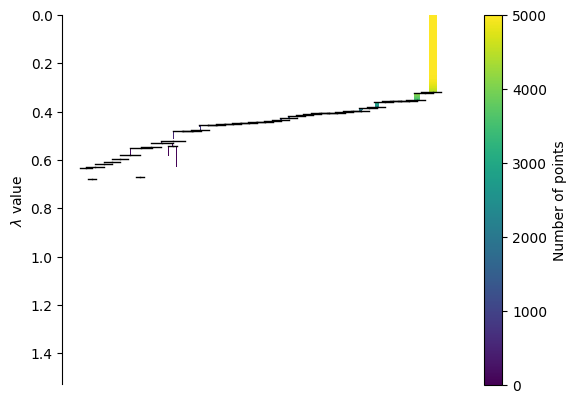

In [ ]:
clusterer.condensed_tree_.plot()

In [ ]:
clusterer.single_linkage_tree_.get_clusters(0.023, min_cluster_size=2)

array([-1, -1, -1, ..., -1, -1, -1])

In [56]:
print(len(clusterer.condensed_tree_.to_pandas()))

508


In [66]:
lams = [0.01, 0.1, 0.2, 0.3, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0,2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 4.0, 5.0]
for lam in lams:
    labels = clusterer.single_linkage_tree_.get_clusters(lam, min_cluster_size=2)
    print(len(labels))
    print(f"λ={lam}: クラスタ数={len(np.unique(labels))}")

5000
λ=0.01: クラスタ数=1
5000
λ=0.1: クラスタ数=1
5000
λ=0.2: クラスタ数=1
5000
λ=0.3: クラスタ数=1
5000
λ=0.3: クラスタ数=1
5000
λ=0.4: クラスタ数=1
5000
λ=0.5: クラスタ数=2
5000
λ=0.6: クラスタ数=2
5000
λ=0.7: クラスタ数=3
5000
λ=0.8: クラスタ数=6
5000
λ=0.9: クラスタ数=8
5000
λ=1.0: クラスタ数=8
5000
λ=1.5: クラスタ数=13
5000
λ=1.6: クラスタ数=15
5000
λ=1.7: クラスタ数=15
5000
λ=1.8: クラスタ数=13
5000
λ=1.9: クラスタ数=15
5000
λ=2.0: クラスタ数=19
5000
λ=2.1: クラスタ数=15
5000
λ=2.2: クラスタ数=20
5000
λ=2.3: クラスタ数=17
5000
λ=2.4: クラスタ数=18
5000
λ=2.5: クラスタ数=19
5000
λ=2.6: クラスタ数=21
5000
λ=2.7: クラスタ数=10
5000
λ=2.8: クラスタ数=8
5000
λ=2.9: クラスタ数=5
5000
λ=3.0: クラスタ数=4
5000
λ=4.0: クラスタ数=2
5000
λ=5.0: クラスタ数=2


In [42]:
proj = run_umap(X)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
print(len(clusterer))

15


In [67]:
labes = clusterer.single_linkage_tree_.get_clusters(2.0, min_cluster_size=2)
print(len(labes))
print(f"unique label: {np.unique(labes)}")

5000
unique label: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


# a

In [91]:
lams = [1.0, 2.0, 2.2, 2.5, 3.0, 4.0, 5.0]
labels = [clusterer.single_linkage_tree_.get_clusters(lam, min_cluster_size=3) for lam in lams ]
# unique len
for lab in labels:
    print(len(np.unique(lab)))    
plot_hierarchical_scatter(proj, labels, params=lams)

8
12
13
10
4
2
2
n_facets: 7


In [ ]:
X, y = load_mnist(5000)